In [1]:
import torch
print(torch.__version__)

2.5.1+cu124


In [2]:
import numpy as np
import os, copy, time, json, cv2, random
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.datasets.utils import download_and_extract_archive
import torchvision.transforms as T
from torchsummary import summary

import detectron2
from detectron2        import model_zoo
from detectron2.model_zoo.model_zoo import _ModelZooUrls
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import detection_utils as utils
from detectron2.utils.visualizer import Visualizer
from detectron2.data             import MetadataCatalog, DatasetCatalog
from detectron2.structures       import BoxMode
from detectron2.data.datasets    import register_coco_instances, load_coco_json
from detectron2.utils.logger     import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation       import COCOEvaluator, inference_on_dataset
from detectron2.data             import build_detection_test_loader, build_detection_train_loader
from detectron2.model_zoo.model_zoo import _ModelZooUrls
from tqdm.notebook import tqdm, trange

import pandas as pd

# from albumentations.pytorch import ToTensorV2
# import albumentations as A

import shutil
from urllib.request import urlretrieve

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION  = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

mz = _ModelZooUrls()
# print("\n".join(list(mz.CONFIG_PATH_TO_URL_SUFFIX.keys())))

torch:  2.5 ; cuda:  cu124


In [3]:
def get_stone_dict(pwd, anno_filename, img_catalog = ''):

    anno_file = anno_filename 
    print(anno_file)
    with open(anno_file) as f:
        data = json.load(f)
    
    dataset_dicts = []
    
    for img in data['images']:
        record = {}
    
        filename = os.path.basename(img["file_name"]).replace(":", "_")
        filename = os.path.join(img_catalog, filename)
        # print(filename)
        record["file_name"] = filename
        record["image_id"] = img['id']
        record["height"] = img['height']
        record["width"] = img['width']
    
        objs = []
        cnt = 0
        for anno in data['annotations']:
            if anno['image_id'] == record["image_id"]:
                obj = {
                        "bbox" : anno['bbox'],
                        "bbox_mode": BoxMode.XYWH_ABS,
                        #"bbox_mode" : BoxMode.XYXY_ABS,
                        "segmentation": anno['segmentation'],
                        "category_id": 0, #anno['category_id'] - 1,
                        # anno['category_id'],
                        "iscrowd": 0,
                        }
                cnt += 1
                
                objs.append(obj)
                
        if cnt:
            record["annotations"] = objs
            dataset_dicts.append(record)

    
    return dataset_dicts

In [18]:
!ls ./

Autogen.ipynb		   coco_annotations_P_3.json   OpenPits_detect.ipynb
coco_annotations_P_0.json  Detectron2_open_pits.ipynb  output
coco_annotations_P_1.json  ImgGen		       predictions_p_0.json
coco_annotations_P_2.json  IMG_PATH


In [19]:
dataset_train_dicts = get_stone_dict("./IMG_PATH", 'coco_annotations_P_1.json', 'IMG_PATH/P_1')

coco_annotations_P_1.json


### Check out

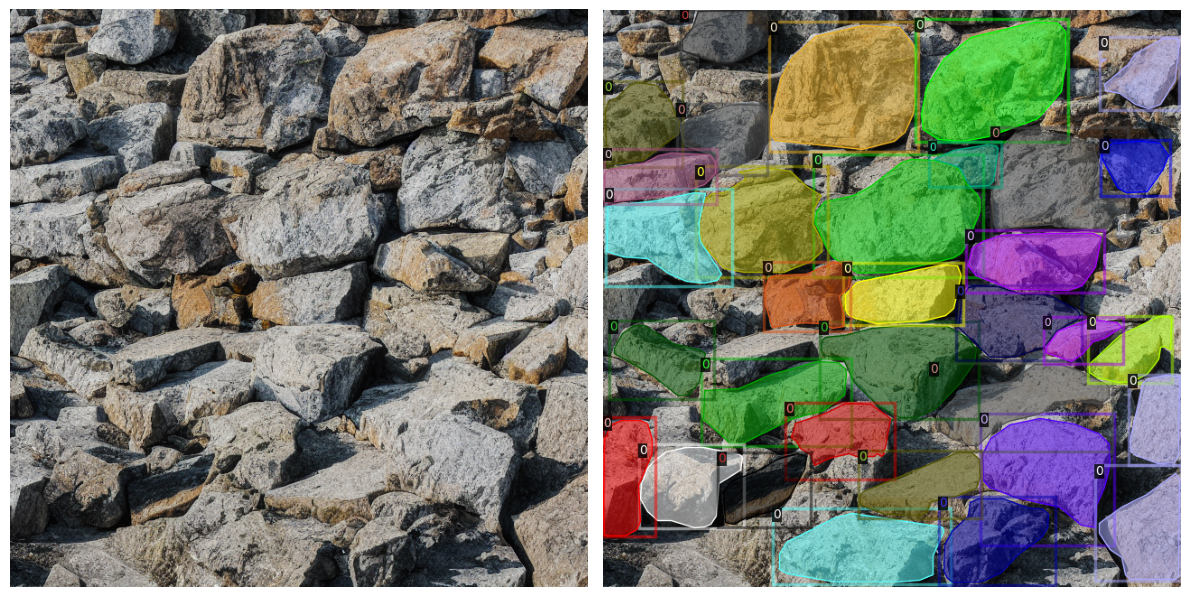

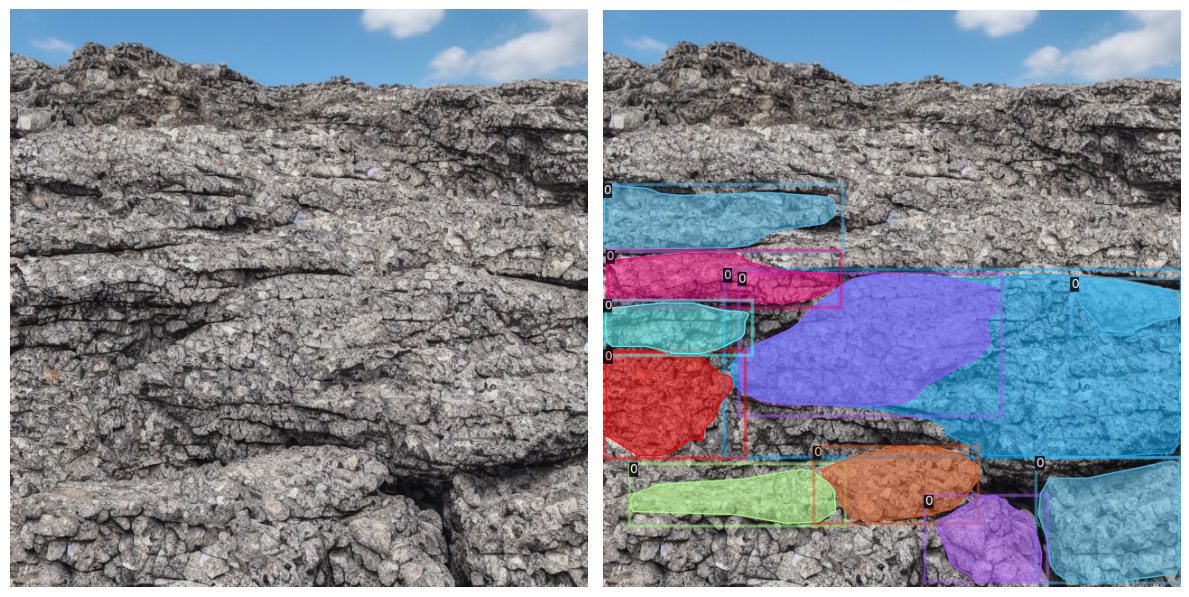

In [23]:
for d in random.sample(dataset_train_dicts, 2):
    img   = Image.open(d["file_name"])
    rgb_im = img.convert('RGB')
    _,axs = plt.subplots(1,2,figsize=(12,8))
    axs[0].imshow(rgb_im); axs[0].axis('off')
    visualizer = Visualizer(rgb_im, metadata=stone_train_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    axs[1].imshow(out.get_image()); axs[1].axis('off')
    plt.tight_layout();plt.show()

# Train

In [10]:
import detectron2.data.transforms as T

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [
                        T.Resize((800,600)),
                        T.RandomBrightness(0.8, 1.8),
                        T.RandomContrast(0.6, 1.3),
                        T.RandomSaturation(0.8, 1.4),
                        T.RandomRotation(angle=[90, 90]),
                        T.RandomLighting(0.7),
                        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
                    ]

    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]

    instances = utils.annotations_to_instances(annos, image.shape[:2])

    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict



In [10]:
from detectron2.config import CfgNode, LazyConfig, get_cfg, instantiate
import pkg_resources

# model_cfg = "new_baselines/mask_rcnn_regnety_4gf_dds_FPN_200ep_LSJ"
# model_zoo.get_checkpoint_url(model_cfg)
# model_cfg = "new_baselines/mask_rcnn_regnety_4gf_dds_FPN_200ep_LSJ.py"
# cfg_file = pkg_resources.resource_filename(
#         "detectron2.model_zoo", os.path.join("configs", "new_baselines/mask_rcnn_regnety_4gf_dds_FPN_200ep_LSJ.py")
#     )

# cfg_file.endswith(".py")
# cfg_l = LazyConfig.load(cfg_file)
# cfg_l

In [11]:
from detectron2.data import get_detection_dataset_dicts
import json

In [27]:
!pwd


/wdata/Project_Practicum/URFU_project/TERM_2


In [8]:
BATCH = 2

cfg = get_cfg()
# model_config = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" # model - model_final.pth_1
# model_config = "COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml" # model - model_final.pth_2
# model_config = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml" # model - model_final.pth_3

#model_config = "COCO-Detection/faster_rcnn_R_101_C4_3x.yaml" # model - model_final.pth_4
# model_config = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml" # model - model_final.pth_5
# model_config = "COCO-Detection/retinanet_R_101_FPN_3x.yaml" # model - model_final.pth_6
# model_config = "COCO-Detection/retinanet_R_50_FPN_3x.yaml" # model - model_final.pth_7

# model_config = "Misc/cascade_mask_rcnn_R_50_FPN_1x.yaml" # model - model_final.pth_8
model_config = "Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml" # model - model_final.pth_9

# model_config = "Misc/scratch_mask_rcnn_R_50_FPN_9x_syncbn.yaml"

cfg.merge_from_file(model_zoo.get_config_file(model_config))

cfg.DATASETS.TRAIN = ("stone_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = BATCH
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 400    # 1000 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)


# PY config TODO
# model_config_py = "new_baselines/mask_rcnn_regnety_4gf_dds_FPN_200ep_LSJ.py"

# cfg_model = model_zoo.get_config(model_config_py)

# cfg_model['dataloader']['train']['dataset']['names'] = "asbest"

### EVALUATOR

In [28]:
!pip install -q coco_eval

In [29]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("stone_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "stone_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[10/09 08:16:16 d2.evaluation.coco_evaluation]: Trying to convert 'stone_val' to COCO format ...
WARNING [10/09 08:16:16 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/stone_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[10/09 08:16:16 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   stone    | 3953         |
|            |              |
[10/09 08:16:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/09 08:16:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/09 08:16:16 d2.data.common]: Serializing 25 elements to byte tensors and concatenating them all ...
[10/09 08:16:16 d2.data.common]: Serialized dataset takes 3.78 MiB
[10/09 08:16:16 d2.evaluati